### Multivariate time series prediction using MLP


Here is a PyTorch implementation of a fully connected neural network which has in total 4 fully connected layers. This is a fully connected
neural network model to be used for multivariate time series prediction. The model has following configurations.

- Number of Layers : 4 (overall).
- Sequence Length (Lookback window) : 13 (hours)
- Prediction Length : 1 (hour)
- Number of features : 7

How does it work:

- Single input: 7 x 13 matrix (features x sequence length)
- Single output: 1 (gauge height in next hour)

Note: Biases exist but are not mentioned below for simplcity.

- First Layer: 7 x 13 (matrix) x 13 x 100 (weight matrix) => 7 x 100 (output)
- Second Layer: 7 x 100 (from last layer) x 100 x 1 (weight matrix) => 7 x 1 (output)
- Transpose: 1 x 7
- Third Layer: 1 x 7 (from last layer after transposing) x 7 x 20 (weight matrix) => 1 x 20
- Fourth Layer: 1 x 20 (from last layer) x 20 x 1 (weight matrix) => 1 x 1 (essentially one value)

The network uses ReLU as activation function at the output of each layer except the final layer.
It uses Mean Square Error (MSELoss) to calculate the model loss.
NSE and WAPE are used for model evaluation.
Data: It uses hourly gauge height data. The data is normalized using MinMaxScaler. It is divided in the ration of 7:1:2 for training, validation and testing respectively.



<i>Important Note: This is a simple FCN network. It is supposed to teach you about simple neural networks. In reality, it doesn't capture the timeseries data well, it's not designed to do so. There exists MLP based networks like N-BEATS, N-HiTS, TiDE, TCN,etc that are more specifically designed to do time series prediction. Please look them up if you want to use MLP based neural networks for time series prediction.</i>

In [17]:
## Write the above description in more organized way, like
# No. of layers =  4
# Sequence length = 24, etc.

import torch
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [22]:
from google.colab import files
uploaded = files.upload()

#you do not need this is if you just drag the file or upload it in the folder

Saving final_data.csv to final_data (1).csv


In [23]:
import pandas as pd

df = pd.read_csv("final_data.csv")
df.head()


,DATE,Precip,WetBulbTemp,DryBulbTemp,RelHumidity,WindSpeed,StationPressure,gauge_height
0,2008-01-01 01:00:00,0.0,37.0,38.0,89.0,0.0,29.19,5.6450
1,2008-01-01 02:00:00,0.0,38.0,39.0,89.0,5.0,29.18,5.5425
2,2008-01-01 03:00:00,0.0,38.0,40.0,86.0,5.0,29.18,5.4575
3,2008-01-01 04:00:00,0.0,38.0,40.0,86.0,6.0,29.19,5.3625
4,2008-01-01 05:00:00,0.0,41.0,45.0,68.0,11.0,29.21,5.2175


In [27]:
# Use hourly data, use a subset to reduce the datasize
path = "final_data.csv"

#path = 'C/Users/arezaie/Downloads/final_data.csv'


In [28]:
# Implement determinism. Set a fixed value for random seed so that when the parameters are initialized, they are initialized same across all experiments.
torch.manual_seed(42)

Here we define **RiverData** a custom Dataset class to load the dataset we have. It extends the pytorch's **Dataset** class.  
- We need to define \_\_init__() function which can be used for loading data from file and optionally for data preprocessing.
- Thereafter we define \_\_len__() function which gives the length of dataset.
- Then we define \_\_getitem__() function which returns an instance of (feature, label) tuple which can be used for model training.
  For our time series data, feature means the past values to be used for training and label means the future values to be predicted.

In [29]:
# we need to put in pre-requisite the knowledge for object oriented programming
# send emails to partcipants to go through it.

class RiverData(torch.utils.data.Dataset):

    def __init__(self, df, target, datecol, seq_len, pred_len):
        self.df = df
        self.datecol = datecol
        self.target = target
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.setIndex()


    def setIndex(self):
        self.df.set_index(self.datecol, inplace=True)


    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len


    def __getitem__(self, idx):
        if len(self.df) <= (idx + self.seq_len+self.pred_len):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self.df)}")
        df_piece = self.df[idx:idx+self.seq_len].values
        feature = torch.tensor(df_piece, dtype=torch.float32)
        label_piece = self.df[self.target][idx + self.seq_len:  idx+self.seq_len+self.pred_len].values
        label = torch.tensor(label_piece, dtype=torch.float32)
        return (feature.T, label)

### Normalize the data

In [30]:
df = pd.read_csv(path)
df.reset_index(inplace=True)
df = df[df['DATE'] > '2012']

df.drop('index', axis=1, inplace=True)
raw_df = df.drop('DATE', axis=1, inplace=False)
scaler = MinMaxScaler()

# Apply the transformations
df_scaled = scaler.fit_transform(raw_df)

df_scaled = pd.DataFrame(df_scaled, columns=raw_df.columns)
df_scaled['DATE'] = df['DATE']
df = df_scaled

Some advanced python syntax have been used here \
*common_args : it's used to pass arguments to a function, where common_args represents a python list \
**common_args: it's used to pass arguments to a function, where common_args represents a python dictionary

In [31]:
# Ratio for train:test:validation is 7:2:1
# we can vary it depending on the dataset

train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

seq_len = 13
pred_len = 1
num_features = 7

common_args = ['gauge_height', 'DATE', seq_len, pred_len]
train_dataset = RiverData(df[:train_size], *common_args)
val_dataset = RiverData(df[train_size: train_size+val_size], *common_args)
test_dataset = RiverData(df[train_size+val_size : len(df)], *common_args)


In [32]:
# Important hyperparameters

BATCH_SIZE = 512 # keep as big as can be handled by GPU and memory
SHUFFLE = False # we don't shuffle the time series data
DATA_LOAD_WORKERS = 1 # it depends on amount of data you need to load
learning_rate = 1e-3 # Learning rate

In [33]:
from torch.utils.data import DataLoader

common_args = {'batch_size': BATCH_SIZE, 'shuffle': SHUFFLE}
train_loader = DataLoader(train_dataset, **common_args)
val_loader = DataLoader(val_dataset, **common_args)
test_loader = DataLoader(test_dataset, **common_args)

### Here we define our pytorch model.

BasicMLPNetwork is the model class, it extends the **Module** class provided by pytorch. \
- We define \_\_init__() function. It sets up layers and defines the model parameters.
- Also, we define forward() function which defines how the forwared pass computation occurs

In [34]:
class BasicMLPNetwork(torch.nn.Module):

    def __init__(self, seq_len, pred_len):
        # call the constructor of the base class
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features
        hidden_size_time = 100
        hidden_size_feat = 20
        # define layers for combining across time series
        self.fc1 = torch.nn.Linear(self.seq_len, hidden_size_time)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size_time, self.pred_len)

        # define layers for combining across the features
        self.fc3 = torch.nn.Linear(self.num_features, hidden_size_feat)
        self.fc4 = torch.nn.Linear(hidden_size_feat, 1)

    def forward(self, x):

        # computation over time
        out = self.fc1(x) #  7 x 100
        out = self.relu(out)
        out = self.fc2(out) # 7 x 1
        out = self.relu(out)

        # computation over features
        out = out.transpose(1,2) # dimension 1 x 7
        out = self.fc3(out) # dimension 1 x 7 x 7 x 20 =  1 x 20
        out = self.relu(out)
        out = self.fc4(out) # dimension 1 x 20 x 20 x 1 = 1 x 1

        out = out.squeeze(-1) # output 1 value

        return out

# Note that the gradients are stored insize the FC layer objects
# For each training example we need to get rid of these gradients

In [35]:
model = BasicMLPNetwork(seq_len, pred_len)
loss = torch.nn.MSELoss()

# there are different optimizer methods, here we're using Adam Optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [46]:

#DO NOT RUN THIS IF THE EARLIER BLOCK IS BEING USED.
#we are chaning the optimzing function here

model = BasicMLPNetwork(seq_len, pred_len)
loss = torch.nn.MSELoss()

# there are different optimizer methods, here we're using Adam Optimizer.
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

In [47]:
for gen in model.parameters():
    print(gen.shape)

torch.Size([100, 13])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])
torch.Size([20, 7])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


In [48]:
for i, (f,l) in enumerate(train_loader):
    print('features shape: ', f.shape)
    print('labels shape: ', l.shape)
    break

features shape:  torch.Size([512, 7, 13])
labels shape:  torch.Size([512, 1])


In [49]:
# define metrics
import numpy as np
epsilon = np.finfo(float).eps

def wape_function(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse_function(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader, plot=False):
    # following line prepares the model for evaulation mode. It disables dropout and batch normalization if they have
    # are part of the model. For our simple model it's not necessary. Still I'm going to use it.

    model.eval()
    all_inputs = torch.empty((0, num_features, seq_len))
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        all_inputs = torch.vstack((all_inputs, inputs))
        all_labels = torch.vstack((all_labels, labels))

    with torch.no_grad():
        outputs = model(all_inputs)
        nse = nse_function(all_labels.numpy(), outputs.numpy())
        wape = wape_function(all_labels.numpy(), outputs.numpy())

    print(f'NSE : {nse} ', end='')
    print(f'WAPE : {wape} ')

    if plot:
        plt.figure(figsize=(16, 6))
        plt.plot(np.array(all_labels.cpu()[:400]), color='green', label='observations')
        plt.plot(np.array(outputs.cpu()[:400]), color='red', linestyle='-', label='predictions')
        metrics_text = f"NSE: {nse:.3f}\nWAPE: {wape:.3f}"
        plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.legend()
        plt.show()

    model.train()
    return nse, wape


In [50]:
num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss_val = loss(outputs, labels)

        # calculate gradients for back propagation
        loss_val.backward()

        # update the weights based on the gradients
        optimizer.step()

        # reset the gradients, avoid gradient accumulation
        optimizer.zero_grad()
        epoch_loss.append(loss_val.item())

    print(f'Epoch {epoch+1}: {sum(epoch_loss)/len(epoch_loss)} ', end='')
    nse, wape = evaluate_model(model, val_loader)





Epoch 1: 0.0072884069012060775 NSE : 0.5223268270492554 WAPE : 26.943634209725047 
Epoch 2: 0.0022115005961941218 NSE : 0.8388764262199402 WAPE : 15.213332950049915 
Epoch 3: 0.0012113237198779748 NSE : 0.8998450040817261 WAPE : 11.960164943509517 
Epoch 4: 0.0009204262059206149 NSE : 0.9302316308021545 WAPE : 9.907534966520702 
Epoch 5: 0.0007954850831852707 NSE : 0.9445722103118896 WAPE : 8.7145387382259 
Epoch 6: 0.0006957540157258483 NSE : 0.9552466869354248 WAPE : 7.753322156294323 
Epoch 7: 0.0006462632907812731 NSE : 0.9612585306167603 WAPE : 7.1519901573254785 
Epoch 8: 0.0005926979138410804 NSE : 0.9656847715377808 WAPE : 6.728484709009884 
Epoch 9: 0.0005608318306075178 NSE : 0.968620240688324 WAPE : 6.424484184704352 
Epoch 10: 0.0005189475630308054 NSE : 0.9709039926528931 WAPE : 6.2157479083143885 


NSE : 0.9755172729492188 WAPE : 6.585897510116959 


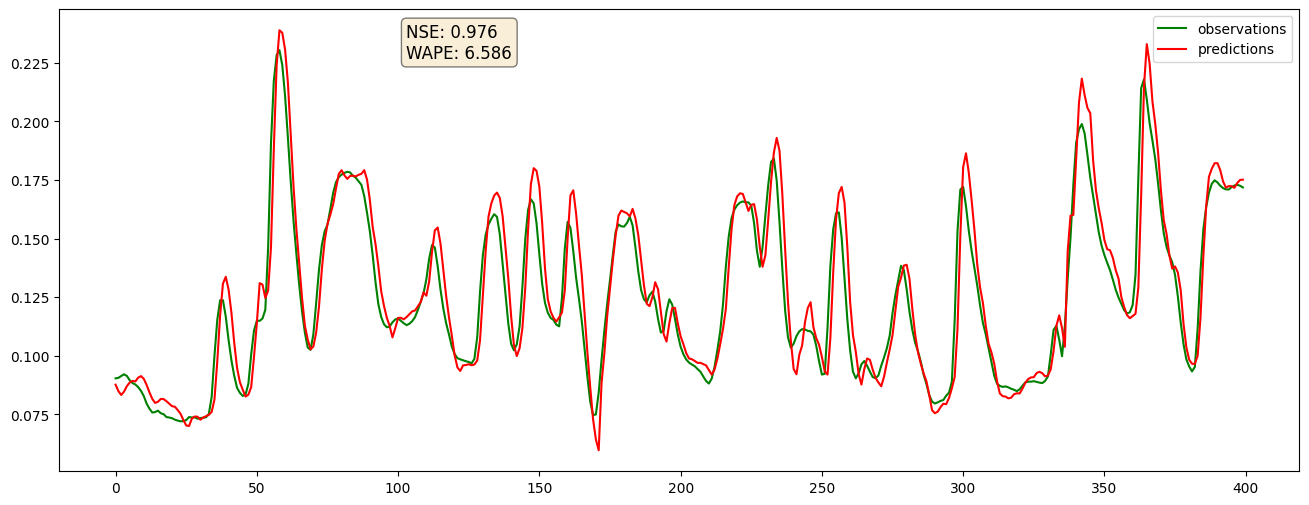

(np.float32(0.9755173), np.float64(6.585897510116959))

In [51]:

evaluate_model(model, test_loader, True)


## Write code for plotting the observed values and predictions.